
# Rating Sports Teams: Elo vs. Win Loss

## Companion notebook for Medium article


In [1]:

import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
sys.path.append('../oddsmaker/')

from copy import copy
from state_space import Elo
from itertools import combinations
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from utils import create_fake_Elo_ratings, create_Elo_random_walk





In the article I state:  
"Elo fundamentally relies on the sigmoid function to relate rating difference to win probability"  
This is the associated figure


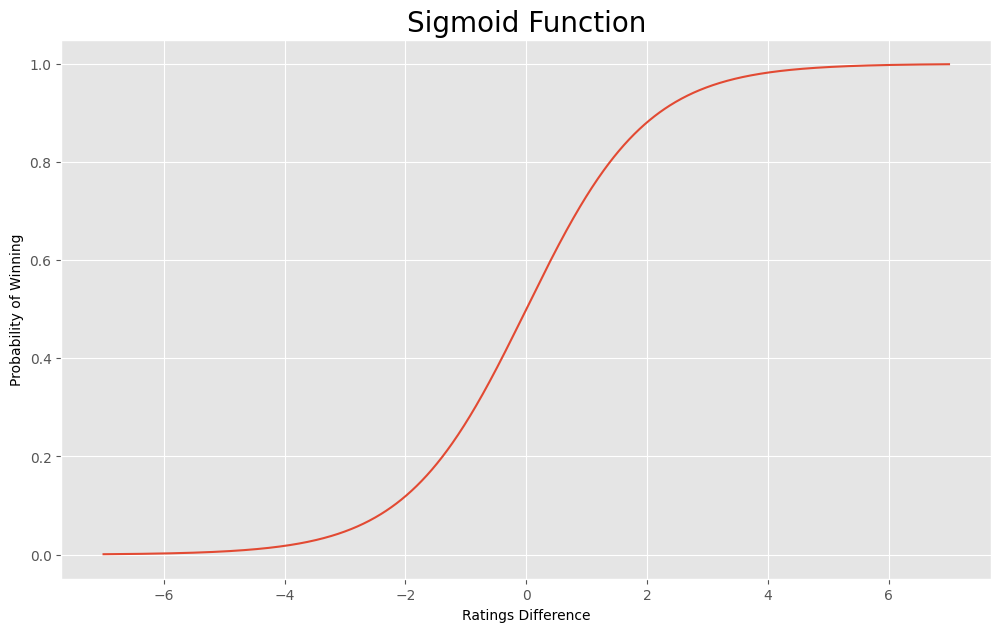

In [2]:


def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.linspace(-7, 7, 1000)
y = sigmoid(x)

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(x, y)
ax.set_title('Sigmoid Function',fontsize=20)
ax.set_ylabel('Probability of Winning')
ax.set_xlabel('Ratings Difference')
# img = mpimg.imread('C:\\Users\Blake\Downloads\CodeCogsEqn.png')
#The OffsetBox is a simple container artist.
# imagebox = OffsetImage(img, zoom = 1.25)
# #Container for the imagebox referring to a specific position *xy*.
# ab = AnnotationBbox(imagebox, (-5, 0.8), frameon = False)
# ax.add_artist(ab)

# plt.savefig('C:\\Users\Blake\Downloads\medium_sigmoid.png')
plt.show()



Below, I assume a group of players have a normal distribution of skill. This is actually the case in the real world fairly often. While maybe not exactly normal, it's often the case the normal distribution is a good approximation. 


In [3]:

# from oddsmaker.utils import create_fake_Elo_ratings, create_Elo_random_walk

## Initialize "True" ratings and assign to fake names
player_rating_dict = create_fake_Elo_ratings(num_players=24, mean=1500, std_dev=250)

## Showing sample ratings
pd.DataFrame({
    'names':player_rating_dict.keys(),
    'true_rating':player_rating_dict.values()
}).head(10)


,names,true_rating
0,Kimberly Silva,1461.061914
1,Richard Santos,1531.353172
2,Johnny Sutton,895.152012
3,Grace Kramer,1498.819459
4,Jay Williams,1470.113351
5,Jessica Hoover,1602.130053
6,Jennifer Herrera,1455.046553
7,Justin Mcdonald,1900.482203
8,Steven Estrada,1632.494623
9,Jeremy Walker,1495.188463



The function below creates a random walk where after each rating period a player's true skill is nudged up or down a random amount between -10 and 10 elo points. 


In [4]:

stat = 'sportsball'
step_size = 10
num_rounds = 2500

sports_data = create_Elo_random_walk(player_rating_dict, num_rounds=num_rounds, step_size=step_size, stat=stat)
sports_data.head()



,player_a,player_b,rating_period,player_a_true,player_b_true,true_prob,result,stat
0,Annette Kelly,Cheryl English,1,1652.073761,1518.351507,0.683471,0,sportsball
1,Anthony Matthews,Grace Kramer,1,1634.716389,1498.819459,0.686173,0,sportsball
2,Cheryl English,Annette Kelly,1,1518.351507,1652.073761,0.316529,1,sportsball
3,Craig Black,Matthew Smith,1,1478.114784,1456.437543,0.531156,1,sportsball
4,Dawn Oneill,Steven Estrada,1,1285.753771,1632.494623,0.119623,0,sportsball


In [5]:

name_1 = sports_data.player_a.unique()[0]
name_2 = sports_data.player_a.unique()[1]


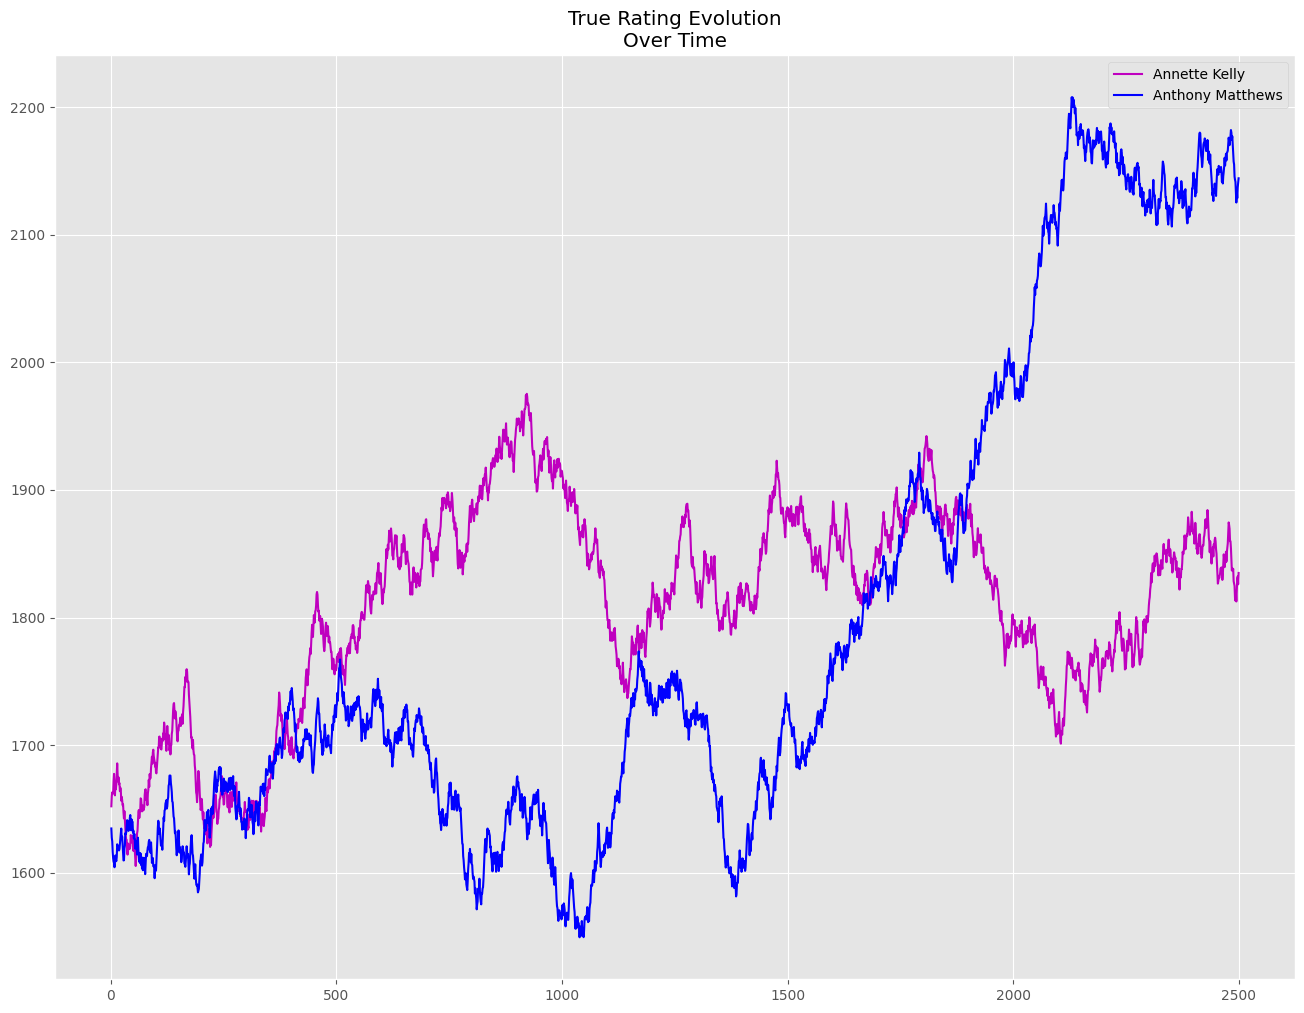

In [6]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

player_1 = sports_data.loc[sports_data['player_a']==name_1].copy().reset_index(drop=True)
player_2 = sports_data.loc[sports_data['player_a']==name_2].copy().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(16,12))

ax.plot(player_1.rating_period, player_1.player_a_true, label=name_1, c='m')
ax.plot(player_2.rating_period, player_2.player_a_true, label=name_2, c='b')
ax.set_title("True Rating Evolution\nOver Time")

ax.legend()
plt.show()


In [7]:

# from oddsmaker.state_space import Elo

elo = Elo(sports_data, protag_id='player_a', antag_id='player_b', k=12, hfa=0)

## use info to inspect 
elo.info()

## get pregame ratings
history, score = elo.run_history()
print(score)
history.head()


There are 1 stats: ['sportsball']
There are 24 unique players/teams.
There are 30,000 games over 2499 rating periods.


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1460.90it/s]


0.1266999549351366


,rating_period,player_a,player_b,is_home,hfa,stat,result,pregame_rating,pregame_opp_rating,rating_adjustment,probability
0,1,Annette Kelly,Cheryl English,0,0,sportsball,0,1500.0,1500.0,-6.0,0.5
1,1,Anthony Matthews,Grace Kramer,0,0,sportsball,0,1500.0,1500.0,-6.0,0.5
2,1,Cheryl English,Annette Kelly,0,0,sportsball,1,1500.0,1500.0,6.0,0.5
3,1,Craig Black,Matthew Smith,0,0,sportsball,1,1500.0,1500.0,6.0,0.5
4,1,Dawn Oneill,Steven Estrada,0,0,sportsball,0,1500.0,1500.0,-6.0,0.5


In [8]:

## find optimal params
## optimizing for 60ish iterations

# elo.optimize()


In [9]:


## run with best params and merge in rating prediction history
history, score = elo.run_history(k=14)
print(score)
sports_data = sports_data.merge(history[['rating_period','player_a','pregame_rating','pregame_opp_rating']], how='left', on=['rating_period','player_a'])


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1468.24it/s]


0.12655526130370467


In [10]:
elo.k

{'sportsball': 12}

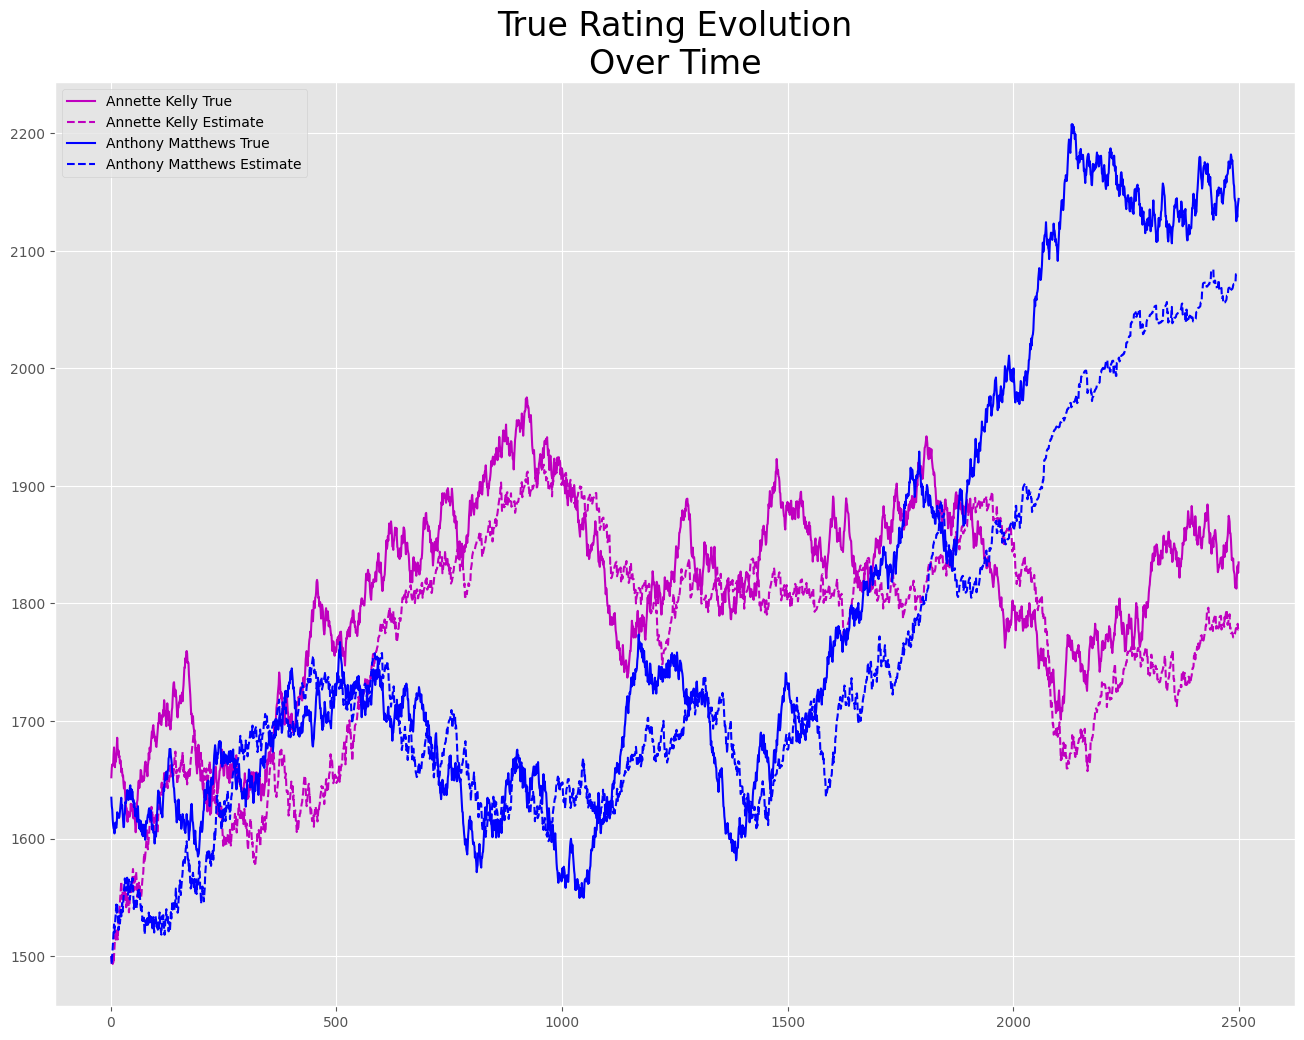

In [11]:

player_1 = sports_data.loc[sports_data['player_a']==name_1].copy().reset_index(drop=True)
player_2 = sports_data.loc[sports_data['player_a']==name_2].copy().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(16,12))

ax.plot(player_1.rating_period, player_1.player_a_true, label=name_1 + ' True', c='m')
ax.plot(player_1.rating_period, player_1.pregame_rating, label=name_1 + ' Estimate', c='m', linestyle='--')
ax.plot(player_2.rating_period, player_2.player_a_true, label=name_2 + ' True', c='b')
ax.plot(player_2.rating_period, player_2.pregame_rating, label=name_2 + ' Estimate', c='b', linestyle='--')
ax.set_title("True Rating Evolution\nOver Time", fontsize=24)

ax.legend()
plt.show()


In [12]:

sports_data['b_result'] = 1-sports_data['result']
sports_data['a_wins'] = sports_data.groupby(['player_a'])['result'].transform(lambda x: x.shift().cumsum()).fillna(0)
sports_data['b_wins'] = sports_data.groupby(['player_b'])['b_result'].transform(lambda x: x.shift().cumsum()).fillna(0)

sports_data['pa'] = sports_data['a_wins'].copy()/sports_data['rating_period'].copy()
sports_data['pb'] = sports_data['b_wins'].copy()/sports_data['rating_period'].copy()
sports_data['pa'] = np.where(sports_data['rating_period']==1, 0.5, sports_data['pa'])
sports_data['pb'] = np.where(sports_data['rating_period']==1, 0.5, sports_data['pb'])

sports_data['log5_prob'] = (sports_data['pa']-(sports_data['pa']*sports_data['pb']))/(sports_data['pa']+sports_data['pb']-(2*sports_data['pa']*sports_data['pb']))
sports_data['rtg_diff'] = sports_data['pregame_opp_rating'].copy()-sports_data['pregame_rating']
sports_data['elo_prob'] = 1/(1+10**((sports_data['rtg_diff'])/400))


In [13]:

sports_data['log5_error'] = (sports_data['log5_prob'].copy()-sports_data['result'].copy())**2
sports_data['elo_error'] = (sports_data['elo_prob'].copy()-sports_data['result'].copy())**2


In [14]:

print(sports_data['log5_error'].mean())
print(sports_data['elo_error'].mean())



0.15383742995055646
0.13273873982322906


In [15]:

sports_data['1000g_rolling_log5_error'] = sports_data['log5_error'].rolling(1000, min_periods=100).mean()
sports_data['1000g_rolling_elo_error'] = sports_data['elo_error'].rolling(1000, min_periods=100).mean()


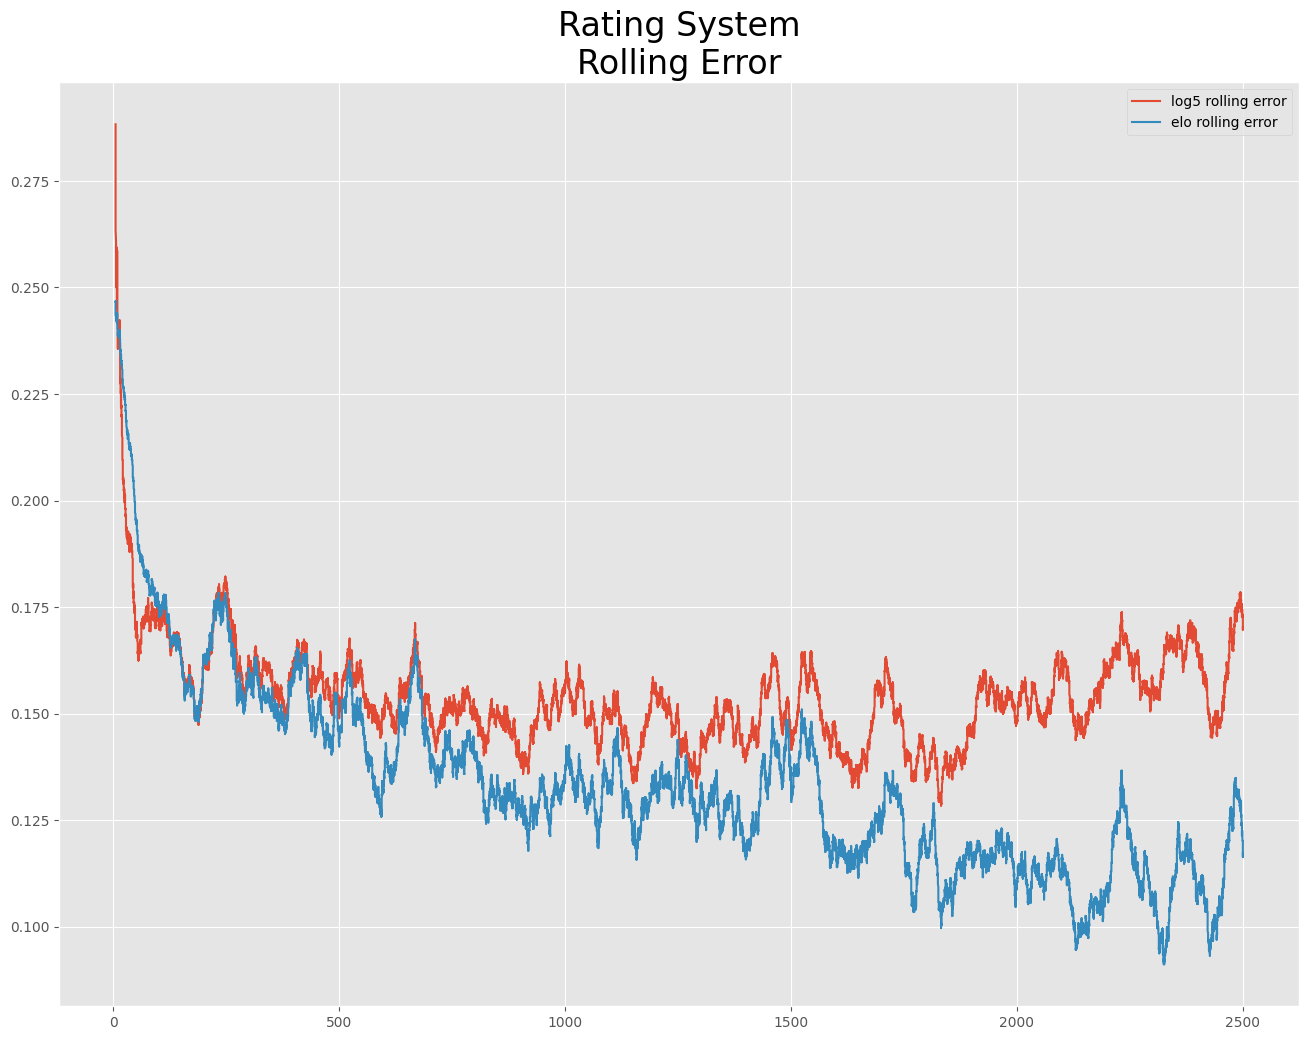

In [16]:

fig, ax = plt.subplots(figsize=(16,12))

ax.plot(sports_data.rating_period, sports_data['1000g_rolling_log5_error'], label='log5 rolling error')
ax.plot(sports_data.rating_period, sports_data['1000g_rolling_elo_error'], label='elo rolling error')

ax.set_title("Rating System\nRolling Error", fontsize=24)
ax.legend()

plt.show()



### Simming multiple seasons

Now I want to compare over 1,000 seasons


In [22]:

def run_sim():
    
    ## create random std_dev
    std_dev_mean = 225
    std_dev_std_dev = 50
    sim_std_dev = np.random.normal(std_dev_mean, std_dev_std_dev)
    
    ## Initialize "True" ratings and assign to fake names
    player_rating_dict = create_fake_Elo_ratings(num_players=24, mean=1500, std_dev=sim_std_dev)
    
    stat = 'sportsball'
    step_size = np.random.normal(9, 3)
    num_rounds = 2000

    sports_data = create_Elo_random_walk(player_rating_dict, num_rounds=num_rounds, step_size=step_size, stat=stat)
    
    elo = Elo(sports_data, protag_id='player_a', antag_id='player_b', k=12, hfa=0)
    ## run with best params and merge in rating prediction history
    history, score = elo.run_history(k=14)
    sports_data = sports_data.merge(history[['rating_period','player_a','pregame_rating','pregame_opp_rating']], how='left', on=['rating_period','player_a'])
    sports_data['b_result'] = 1-sports_data['result']
    sports_data['a_wins'] = sports_data.groupby(['player_a'])['result'].transform(lambda x: x.shift().cumsum()).fillna(0)
    sports_data['b_wins'] = sports_data.groupby(['player_b'])['b_result'].transform(lambda x: x.shift().cumsum()).fillna(0)

    sports_data['pa'] = sports_data['a_wins'].copy()/sports_data['rating_period'].copy()
    sports_data['pb'] = sports_data['b_wins'].copy()/sports_data['rating_period'].copy()
    sports_data['pa'] = np.where(sports_data['rating_period']==1, 0.5, sports_data['pa'])
    sports_data['pb'] = np.where(sports_data['rating_period']==1, 0.5, sports_data['pb'])

    sports_data['log5_prob'] = (sports_data['pa']-(sports_data['pa']*sports_data['pb']))/(sports_data['pa']+sports_data['pb']-(2*sports_data['pa']*sports_data['pb']))
    sports_data['rtg_diff'] = sports_data['pregame_opp_rating'].copy()-sports_data['pregame_rating']
    sports_data['elo_prob'] = 1/(1+10**((sports_data['rtg_diff'])/400))
    
    sports_data['log5_error'] = (sports_data['log5_prob'].copy()-sports_data['result'].copy())**2
    sports_data['elo_error'] = (sports_data['elo_prob'].copy()-sports_data['result'].copy())**2

    log5_error = sports_data['log5_error'].mean()
    elo_error = sports_data['elo_error'].mean()
    return elo_error, log5_error







In [26]:

from tqdm import tqdm
l5_errors = []
elo_errors = []

for i in tqdm(list(range(300))):
    e_error, l5_error = run_sim()
    elo_errors.append(e_error)
    l5_errors.append(l5_error)


 56%|██████████████████████████████████████████▍                                 | 1117/2000 [00:00<00:00, 1516.43it/s]


 25%|███████████████████▎                                                         | 502/2000 [00:00<00:00, 1662.82it/s]


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


 83%|███████████████████████████████████████████████████████████████▎            | 1666/2000 [00:01<00:00, 1683.72it/s]


 57%|███████████████████████████████████████████▏                                | 1138/2000 [00:00<00:00, 1597.28it/s]


 25%|███████████████████▍                                                         | 504/2000 [00:00<00:00, 1601.36it/s]


 11%|████████▉                                                                        | 33/300 [01:05<09:02,  2.03s/it]


 80%|████████████████████████████████████████████████████████████▊               | 1600/2000 [00:01<00:00, 1533.18it/s]


 50%|██████████████████████████████████████                                       | 990/2000 [00:00<00:00, 1626.76it/s]


 33%|█████████████████████████▍                                                   | 661/2000 [00:00<00:00, 1652.60it/s]


  8%|██████▍                                                                      | 168/2000 [00:00<00:01, 1663.42it/s]


 91%|█████████████████████████████████████████████████████████████████████▍      | 1827/2000 [00:01<00:00, 1561.65it/s]


 57%|███████████████████████████████████████████▎                                | 1140/2000 [00:00<00:00, 1583.05it/s]


 25%|███████████████████▎                                                         | 502/2000 [00:00<00:00, 1569.98it/s]


 24%|███████████████████▏                                                             | 71/300 [02:21<07:38,  2.00s/it]


 79%|████████████████████████████████████████████████████████████▎               | 1588/2000 [00:01<00:00, 1425.59it/s]


 71%|██████████████████████████████████████████████████████▏                     | 1425/2000 [00:00<00:00, 1607.63it/s]


 48%|████████████████████████████████████▌                                        | 950/2000 [00:00<00:00, 1450.71it/s]


 40%|██████████████████████████████▌                                              | 795/2000 [00:00<00:00, 1581.14it/s]


 42%|████████████████████████████████▌                                            | 845/2000 [00:00<00:00, 1684.67it/s]


  8%|██████▌                                                                      | 169/2000 [00:00<00:01, 1688.99it/s]


 91%|████████████████████████████████████████████████████████████████████▉       | 1814/2000 [00:01<00:00, 1692.45it/s]


 53%|████████████████████████████████████████▌                                   | 1067/2000 [00:00<00:00, 1468.14it/s]


 40%|██████████████████████████████▋                                              | 797/2000 [00:00<00:00, 1488.02it/s]


  8%|██████▍                                                                      | 168/2000 [00:00<00:01, 1679.78it/s]


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1574.10it/s]


 59%|████████████████████████████████████████████▉                               | 1181/2000 [00:00<00:00, 1378.69it/s]


 33%|█████████████████████████▎                                                   | 658/2000 [00:00<00:00, 1525.78it/s]


  8%|██████▎                                                                      | 164/2000 [00:00<00:01, 1639.08it/s]


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1564.54it/s]


 65%|█████████████████████████████████████████████████▏                          | 1296/2000 [00:00<00:00, 1641.48it/s]


 33%|█████████████████████████▌                                                   | 664/2000 [00:00<00:00, 1567.10it/s]


 26%|███████████████████▊                                                         | 516/2000 [00:00<00:00, 1713.99it/s]


 26%|████████████████████▏                                                        | 525/2000 [00:00<00:00, 1692.38it/s]


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1441.41it/s]


 67%|██████████████████████████████████████████████████▋                         | 1333/2000 [00:00<00:00, 1645.67it/s]


 41%|███████████████████████████████▊                                             | 826/2000 [00:00<00:00, 1648.78it/s]


 17%|████████████▊                                                                | 334/2000 [00:00<00:01, 1311.99it/s]


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1554.61it/s]


 74%|████████████████████████████████████████████████████████▏                   | 1477/2000 [00:00<00:00, 1616.79it/s]


 50%|██████████████████████████████████████▏                                     | 1004/2000 [00:00<00:00, 1650.03it/s]


 25%|███████████████████▏                                                         | 497/2000 [00:00<00:00, 1596.83it/s]


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


 81%|█████████████████████████████████████████████████████████████▋              | 1623/2000 [00:01<00:00, 1605.44it/s]


 50%|██████████████████████████████████████▏                                     | 1006/2000 [00:00<00:00, 1593.05it/s]


  8%|█████▉                                                                       | 154/2000 [00:00<00:01, 1531.86it/s]


 82%|██████████████████████████████████████████████████████████████▌             | 1646/2000 [00:01<00:00, 1611.80it/s]


 35%|███████████████████████████                                                  | 703/2000 [00:00<00:00, 1387.28it/s]


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


 78%|███████████████████████████████████████████████████████████▏                | 1557/2000 [00:01<00:00, 1390.35it/s]


 48%|████████████████████████████████████▉                                        | 958/2000 [00:00<00:00, 1363.73it/s]


 16%|████████████▋                                                                | 328/2000 [00:00<00:01, 1272.72it/s]


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


 84%|████████████████████████████████████████████████████████████████            | 1687/2000 [00:01<00:00, 1602.81it/s]


 65%|█████████████████████████████████████████████████▏                          | 1296/2000 [00:00<00:00, 1352.26it/s]


 33%|█████████████████████████▌                                                   | 664/2000 [00:00<00:00, 1604.40it/s]


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


 90%|████████████████████████████████████████████████████████████████████▋       | 1809/2000 [00:01<00:00, 1570.95it/s]


 50%|██████████████████████████████████████▎                                     | 1007/2000 [00:00<00:00, 1667.48it/s]


 16%|████████████▏                                                                | 316/2000 [00:00<00:01, 1442.44it/s]


 85%|████████████████████████████████████████████████████████████████▎           | 1692/2000 [00:01<00:00, 1570.38it/s]


 57%|███████████████████████████████████████████▏                                | 1136/2000 [00:00<00:00, 1448.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [09:53<00:00,  1.98s/it]


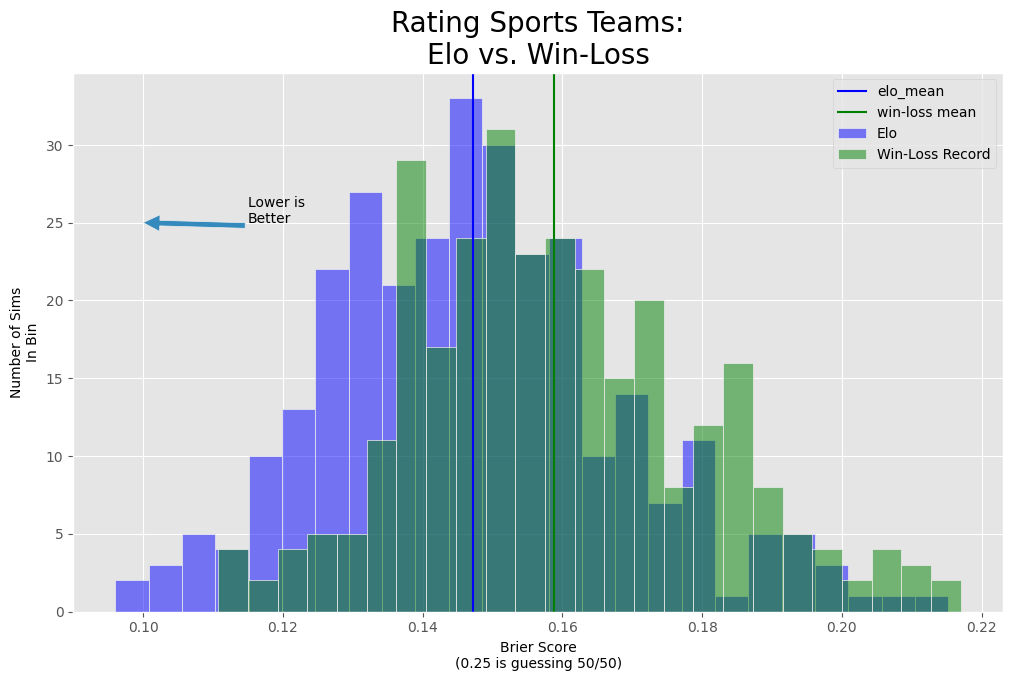

In [61]:

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,7))

elo_mean = np.mean(elo_errors)
l5_mean = np.mean(l5_errors)
sns.histplot(elo_errors, color='blue', ax=ax, bins=25, label='Elo',alpha=0.5)
sns.histplot(l5_errors, color='green', ax=ax, bins=25, label='Win-Loss Record',alpha=0.5)
ax.axvline(elo_mean, color='blue', label='elo_mean')
ax.axvline(l5_mean, color='green', label='win-loss mean')

ax.set_title('Rating Sports Teams:\nElo vs. Win-Loss', fontsize=20)
ax.annotate('Lower is\nBetter',xy=(0.1,25),xytext=(0.115,25),arrowprops={})

ax.legend()
ax.set_ylabel('Number of Sims\nIn Bin')
ax.set_xlabel('Brier Score\n(0.25 is guessing 50/50)')

plt.savefig('C://Users/Blake/Downloads/elo_wl_comparison.png')
plt.show()


In [28]:
elo_errors

[0.13799811652845656,
 0.12784335199811406,
 0.1298117570068499,
 0.16313811689776012,
 0.13763134481389513,
 0.14488689557838488,
 0.11451727888657842,
 0.1417894452755265,
 0.16063594194824213,
 0.16405723829832555,
 0.14474429812279613,
 0.09865654799933189,
 0.15054649361554334,
 0.14922888517278715,
 0.1784978954677382,
 0.14149934967715658,
 0.1029741149117936,
 0.14085848797186307,
 0.14135792345644457,
 0.16841980505696755,
 0.13251771983966604,
 0.16146604335904471,
 0.13650577339593103,
 0.14919867063559514,
 0.14958260350910985,
 0.15194681560612316,
 0.14604580924808905,
 0.13271470566617305,
 0.14326070459588214,
 0.16796725183146444,
 0.1357900296997323,
 0.1226402065358144,
 0.15410953378817752,
 0.1640692116118888,
 0.14501207477892358,
 0.14879709984928946,
 0.15731656391591722,
 0.12864145786806594,
 0.11690482595327441,
 0.14925186344272848,
 0.13336989842484798,
 0.12545962477691006,
 0.13088760748709638,
 0.12875882149078574,
 0.13410741370634893,
 0.14308411480037